# Chapter 5: Eager and Lazy APIs

In [1]:
import polars as pl
pl.show_versions()

--------Version info---------
Polars:               0.20.31
Index type:           UInt32
Platform:             Linux-6.8.0-40-generic-x86_64-with-glibc2.35
Python:               3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]

----Optional dependencies----
adbc_driver_manager:  <not installed>
cloudpickle:          3.0.0
connectorx:           0.3.2
deltalake:            <not installed>
fastexcel:            0.9.1
fsspec:               2023.12.2
gevent:               <not installed>
hvplot:               0.9.2
matplotlib:           3.8.4
nest_asyncio:         1.6.0
numpy:                1.26.4
openpyxl:             3.1.2
pandas:               2.2.2
pyarrow:              14.0.2
pydantic:             <not installed>
pyiceberg:            <not installed>
pyxlsb:               <not installed>
sqlalchemy:           <not installed>
torch:                <not installed>
xlsx2csv:             0.8.2
xlsxwriter:           3.2.0


## Eager API: DataFrame

In [2]:
%%time
trips = pl.read_parquet("data/taxi/yellow_tripdata_*.parquet")
sum_per_vendor = trips.group_by("VendorID").sum()

income_per_distance_per_vendor = sum_per_vendor.select(
    "VendorID",
    income_per_distance=pl.col("total_amount") / pl.col("trip_distance")
)

top_three = (
    income_per_distance_per_vendor.sort(by="income_per_distance", descending=True)
    .head(3)
)
top_three

CPU times: user 14.7 s, sys: 6.27 s, total: 20.9 s
Wall time: 12.6 s


VendorID,income_per_distance
i64,f64
1,6.434789
6,5.296493
5,4.731557


## Lazy API: LazyFrame

### LazyFrame Scan Level Optimizations

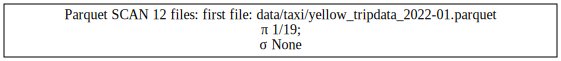

In [4]:
lf = pl.scan_parquet("data/taxi/yellow_tripdata_*.parquet")  # <1>
lf.select(pl.col("trip_distance")).show_graph()  # <2>

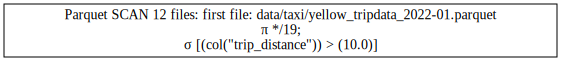

In [5]:
lf.filter(pl.col("trip_distance") > 10).show_graph()

In [9]:
lf.fetch(n_rows=2)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
i64,datetime[ns],datetime[ns],f64,f64,f64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,"""N""",142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.1,1.0,"""N""",236,42,1,8.0,0.5,0.5,4.0,0.0,0.3,13.3,0.0,0.0


In [11]:
lf.filter(pl.col("trip_distance") > 3).fetch(n_rows=2)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
i64,datetime[ns],datetime[ns],f64,f64,f64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,"""N""",142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,4.1,1.0,"""N""",246,151,2,17.0,3.0,0.5,0.0,0.0,0.3,20.8,2.5,0.0


### Other Optimizations

In [19]:
lazy_df = pl.LazyFrame({
    "foo": [1, 2, 3, 4, 5],
    "bar": [6, 7, 8, 9, 10]
})

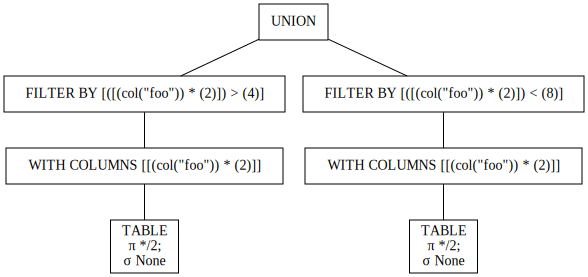

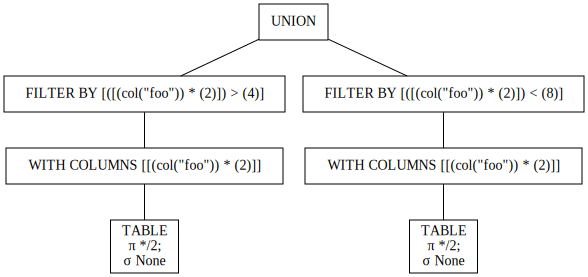

In [21]:
common_subplan = lazy_df.with_columns(pl.col("foo") * 2)

# Utilizing the common subplan in two separate expressions
expr1 = common_subplan.filter(pl.col("foo") * 2 > 4)
expr2 = common_subplan.filter(pl.col("foo") * 2 < 8)

result = pl.concat([expr1, expr2])

result.show_graph(optimized=False)
result.show_graph(optimized=True)

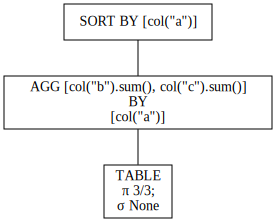

In [17]:
# lf = pl.LazyFrame(
#     {
#         "a": ["a", "b", "a", "b", "b", "c"],
#         "b": [1, 2, 3, 4, 5, 6],
#         "c": [6, 5, 4, 3, 2, 1],
#     }
# )
# lf.group_by("a", maintain_order=True).agg(pl.all().sum()).sort(
#     "a"
# ).show_graph()  

In [29]:
ldf = pl.LazyFrame({
    "name": ["Alice", "Bob", "Charlie"],
    "age": [25, 30, 35]
})

erroneous_query = ldf.with_columns(
    pl.col("age")
    # .str
    .slice(0, 3)
    .alias("sliced_age")
)

result_df = erroneous_query.collect()
result_df

name,age,sliced_age
str,i64,i64
"""Alice""",25,25
"""Bob""",30,30
"""Charlie""",35,35


## Performance Differences

In [32]:
%%time

trips = pl.scan_parquet("data/taxi/yellow_tripdata_*.parquet")
sum_per_vendor = trips.group_by("VendorID").sum()

income_per_distance_per_vendor = sum_per_vendor.select(
    "VendorID",
    income_per_distance=pl.col("total_amount") / pl.col("trip_distance")
)

top_three = (
    income_per_distance_per_vendor.sort(
        by="income_per_distance", 
        descending=True)
).head(3)

top_three.collect()

CPU times: user 2.33 s, sys: 1.02 s, total: 3.35 s
Wall time: 1.35 s


VendorID,income_per_distance
i64,f64
1,6.434789
6,5.296493
5,4.731557


In [33]:
trips.schema

OrderedDict([('VendorID', Int64),
             ('tpep_pickup_datetime',
              Datetime(time_unit='ns', time_zone=None)),
             ('tpep_dropoff_datetime',
              Datetime(time_unit='ns', time_zone=None)),
             ('passenger_count', Float64),
             ('trip_distance', Float64),
             ('RatecodeID', Float64),
             ('store_and_fwd_flag', String),
             ('PULocationID', Int64),
             ('DOLocationID', Int64),
             ('payment_type', Int64),
             ('fare_amount', Float64),
             ('extra', Float64),
             ('mta_tax', Float64),
             ('tip_amount', Float64),
             ('tolls_amount', Float64),
             ('improvement_surcharge', Float64),
             ('total_amount', Float64),
             ('congestion_surcharge', Float64),
             ('airport_fee', Float64)])

In [30]:
lf = pl.LazyFrame({"col1": [1,2,3], "col2": [4,5,6]})
# Some heavy computation
print(lf.collect())
print(lf.with_columns(pl.col("col1") + 1).collect())  # Recalculates the LazyFrame

shape: (3, 2)
┌──────┬──────┐
│ col1 ┆ col2 │
│ ---  ┆ ---  │
│ i64  ┆ i64  │
╞══════╪══════╡
│ 1    ┆ 4    │
│ 2    ┆ 5    │
│ 3    ┆ 6    │
└──────┴──────┘
shape: (3, 2)
┌──────┬──────┐
│ col1 ┆ col2 │
│ ---  ┆ ---  │
│ i64  ┆ i64  │
╞══════╪══════╡
│ 2    ┆ 4    │
│ 3    ┆ 5    │
│ 4    ┆ 6    │
└──────┴──────┘


## Functionality Differences

### Aggregations

### Attributes

### Computation

### Descriptive

### GroupBy

### Exporting

### Manipulation and Selection

### Miscellaneous

## Out-of-Core Computation with Lazy API's Streaming Mode

In [37]:
pl.thread_pool_size()

4

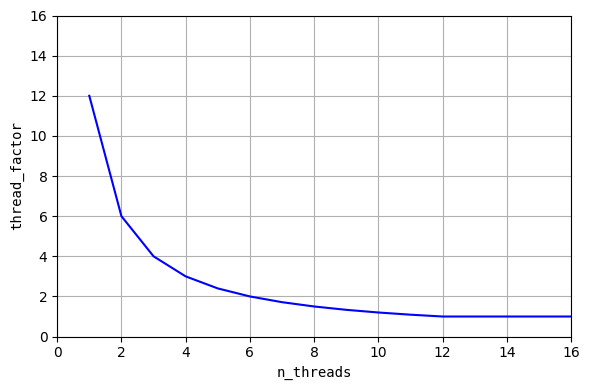

In [35]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, 17)
y = np.maximum(12 / x, 1)

plt.figure(figsize=(6, 4))
plt.plot(x, y, 'b-')
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.xlabel('n_threads', {'fontname':'monospace'})
plt.ylabel('thread_factor', {'fontname':'monospace'})
plt.grid(True)
plt.tight_layout()

plt.show()

In [25]:
pl.Config.set_streaming_chunk_size(1000)

polars.config.Config

## Tips and Tricks

### Going from LazyFrame to DataFrame and Vice Versa

### Joining a DataFrame and a LazyFrame

In [42]:
lf = pl.LazyFrame({"id": [1,2,3], "value1": [4,5,6]})
df = pl.DataFrame({"id": [1,2,3], "value2": [7,8,9]})

# lf.join(df, on="id")
df.join(lf, on="id")

TypeError: expected `other` join table to be a DataFrame, got 'LazyFrame'

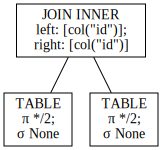

In [45]:
lf = pl.LazyFrame({"id": [1,2,3], "value1": [4,5,6]})
df = pl.DataFrame({"id": [1,2,3], "value2": [7,8,9]})

lf.join(df.lazy(), on="id").show_graph()

### Caching Intermittent Stages

In [47]:
%%time
lf = pl.LazyFrame({"col1": [1,2,3], "col2": [4,5,6]})
# Some heavy computation
lf = lf.collect().lazy()
print(lf.collect())
print(lf.with_columns(pl.col("col1") + 1).collect())  # Utilizes the cached LazyFrame

shape: (3, 2)
┌──────┬──────┐
│ col1 ┆ col2 │
│ ---  ┆ ---  │
│ i64  ┆ i64  │
╞══════╪══════╡
│ 1    ┆ 4    │
│ 2    ┆ 5    │
│ 3    ┆ 6    │
└──────┴──────┘
shape: (3, 2)
┌──────┬──────┐
│ col1 ┆ col2 │
│ ---  ┆ ---  │
│ i64  ┆ i64  │
╞══════╪══════╡
│ 2    ┆ 4    │
│ 3    ┆ 5    │
│ 4    ┆ 6    │
└──────┴──────┘
CPU times: user 450 μs, sys: 0 ns, total: 450 μs
Wall time: 2.14 ms


In [49]:
%%time

trips = pl.scan_parquet("data/taxi/yellow_tripdata_*.parquet")
sum_per_vendor = trips.group_by("VendorID").sum()

income_per_distance_per_vendor = sum_per_vendor.select(
    "VendorID",
    income_per_distance=pl.col("total_amount") / pl.col("trip_distance")
)

top_three = (
    income_per_distance_per_vendor.sort(
        by="income_per_distance", 
        descending=True)
).head(3)

top_three.collect()

CPU times: user 2.3 s, sys: 993 ms, total: 3.3 s
Wall time: 1.46 s


VendorID,income_per_distance
i64,f64
1,6.434789
6,5.296493
5,4.731557


In [50]:
%%time

trips = pl.scan_parquet("data/taxi/yellow_tripdata_*.parquet")
trips = trips.collect().lazy()
sum_per_vendor = trips.group_by("VendorID").sum()

income_per_distance_per_vendor = sum_per_vendor.select(
    "VendorID",
    income_per_distance=pl.col("total_amount") / pl.col("trip_distance")
)

top_three = (
    income_per_distance_per_vendor.sort(
        by="income_per_distance", 
        descending=True)
).head(3)

top_three.collect()

CPU times: user 10.8 s, sys: 3.3 s, total: 14.1 s
Wall time: 5.33 s


VendorID,income_per_distance
i64,f64
1,6.434789
6,5.296493
5,4.731557


## Conclusion